In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt


def load_and_aggregate_results(surrogate, acquisition, seeds, base_folder="results_"):
    metrics_keys = ["train_loss", "val_loss", "test_loss", "train_r2", "val_r2", "test_r2"]
    all_metrics = {k: [] for k in metrics_keys}

    for seed in seeds:
        if acquisition == "passive":
            file_path = f"{base_folder}{seed}/history_{acquisition}_rnd{seed}.npz"
        else:
            file_path = f"{base_folder}{seed}/history_{surrogate}_{acquisition}_rnd{seed}.npz"
        
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        data = np.load(file_path, allow_pickle=True)
        for k in metrics_keys:
            all_metrics[k].append(data[k])

    # Convert to numpy arrays and compute mean/std for each metric
    mean_metrics = {}
    std_metrics = {}

    for k in metrics_keys:
        stacked = np.stack(all_metrics[k], axis=0)  # shape: (num_seeds, num_epochs)
        mean_metrics[k] = np.mean(stacked, axis=0)
        std_metrics[k] = np.std(stacked, axis=0)

    return mean_metrics, std_metrics

In [2]:
# Example usage
mean_metrics_example, std_metrics_example = load_and_aggregate_results(
    surrogate="gp",
    acquisition="greedy",
    seeds=[15, 16]
)

df_mean_metrics_mean = pd.DataFrame(mean_metrics_example)
df_mean_metrics_mean.head()

,train_loss,val_loss,test_loss,train_r2,val_r2,test_r2
0,16.580523,16.040491,15.945557,-1.574735,-1.241559,-1.263176
1,14.874601,15.949422,15.854723,-0.906761,-1.228830,-1.250279
2,14.152102,15.845169,15.750682,-0.983269,-1.214258,-1.235508
3,13.404080,15.724614,15.630478,-0.739319,-1.197408,-1.218442
4,13.423543,15.580053,15.486305,-0.905005,-1.177201,-1.197974


In [3]:
df_mean_metrics_std = pd.DataFrame(std_metrics_example)
df_mean_metrics_std.head()

,train_loss,val_loss,test_loss,train_r2,val_r2,test_r2
0,0.064603,0.025662,0.019649,0.000739,0.001553,0.002793
1,0.270351,0.024775,0.018552,0.043885,0.001649,0.002638
2,0.074251,0.022053,0.015494,0.023874,0.001998,0.002204
3,0.043704,0.017209,0.010194,0.016138,0.002639,0.001451
4,0.942768,0.019066,0.011694,0.215279,0.002334,0.001664


In [4]:
color_palette = [
    "blue",  # blue
    "lightcyan",  # soft cyan
    "#ff7f00",  # orange
    "#a65628",  # brown
    "#e41a1c",  # red (optional, not used here)
]
safe_colors = ['blue', 'cyan', 'orange', 'brown']  # blue, purple, orange, brown

# Configuration
surrogates = ['gp', 'rf', 'bayes_linear', 'mc_dropout']
acquisitions = ['greedy', 'mcmc', 'thompson', 'metropolis']
passive_acquisition = 'passive'
seeds = [15, 16, 17]
base_folder = "results_"

# Store all metrics here
all_mean_metrics = {}
all_std_metrics = {}

# Load passive separately (no surrogate)
mean_key = f"passive"
mean_metrics, std_metrics = load_and_aggregate_results(
    surrogate=None,
    acquisition=passive_acquisition,
    seeds=seeds,
    base_folder=base_folder
)
all_mean_metrics[mean_key] = mean_metrics
all_std_metrics[mean_key] = std_metrics

# Load all surrogate+acquisition combos
for surrogate in surrogates:
    for acquisition in acquisitions:
        key = f"{surrogate}_{acquisition}"
        mean_metrics, std_metrics = load_and_aggregate_results(
            surrogate=surrogate,
            acquisition=acquisition,
            seeds=seeds,
            base_folder=base_folder
        )
        all_mean_metrics[key] = mean_metrics
        all_std_metrics[key] = std_metrics

File not found: results_17/history_passive_rnd17.npz
File not found: results_17/history_gp_metropolis_rnd17.npz
File not found: results_16/history_mc_dropout_metropolis_rnd16.npz


In [5]:
def plot_metric_grouped_by_acquisition(
    metric_key,
    surrogate,
    all_mean_metrics,
    all_std_metrics,
    show_passive=True,
    xlim=None,
    ylim=None
):
    acquisitions = ['greedy', 'mcmc', 'thompson', 'metropolis']
    epochs = range(1, len(next(iter(all_mean_metrics.values()))[metric_key]) + 1)

    plt.figure(figsize=(10, 6))
    for idx, acquisition in enumerate(acquisitions):
        key = f"{surrogate}_{acquisition}"
        if key not in all_mean_metrics:
            continue
        mean = all_mean_metrics[key][metric_key]
        std = all_std_metrics[key][metric_key]
        color = safe_colors[idx % len(safe_colors)]
        plt.plot(epochs, mean, label=f"{acquisition}", color=color)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2)

    if show_passive and 'passive' in all_mean_metrics:
        mean = all_mean_metrics['passive'][metric_key]
        std = all_std_metrics['passive'][metric_key]
        plt.plot(epochs, mean, '--', color='gray', label="passive")
        plt.fill_between(epochs, mean - std, mean + std, color='gray', alpha=0.2)

    plt.title(f"{metric_key} for surrogate: {surrogate}")
    plt.xlabel("Epoch or Batch")
    plt.ylabel(metric_key)
    plt.legend()
    
    max_epoch_or_step = max(epochs)
    xticks = np.arange(0, max_epoch_or_step + 1, 52)
    plt.xticks(xticks)
    plt.grid(True)

    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    plt.tight_layout()
    plt.show()


In [6]:
def plot_metric_grouped_by_surrogate(
    metric_key,
    acquisition,
    all_mean_metrics,
    all_std_metrics,
    show_passive=True,
    xlim=None,
    ylim=None
):
    surrogates = ['gp', 'rf', 'bayes_linear', 'mc_dropout']
    epochs = range(1, len(next(iter(all_mean_metrics.values()))[metric_key]) + 1)

    plt.figure(figsize=(10, 6))
    for idx, surrogate in enumerate(surrogates):
        key = f"{surrogate}_{acquisition}"
        if key not in all_mean_metrics:
            continue
        mean = all_mean_metrics[key][metric_key]
        std = all_std_metrics[key][metric_key]
        color = safe_colors[idx % len(safe_colors)]
        plt.plot(epochs, mean, label=f"{surrogate}", color=color)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2)

    if show_passive and 'passive' in all_mean_metrics:
        mean = all_mean_metrics['passive'][metric_key]
        std = all_std_metrics['passive'][metric_key]
        plt.plot(epochs, mean, '--', color='gray', label="passive")
        plt.fill_between(epochs, mean - std, mean + std, color='gray', alpha=0.2)

    plt.title(f"{metric_key} for acquisition: {acquisition}")
    plt.xlabel("Epoch or Batch")
    plt.ylabel(metric_key)
    plt.legend()

    max_epoch_or_step = max(epochs)
    xticks = np.arange(0, max_epoch_or_step + 1, 52)
    plt.xticks(xticks)
    plt.grid(True)

    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    plt.tight_layout()
    plt.show()


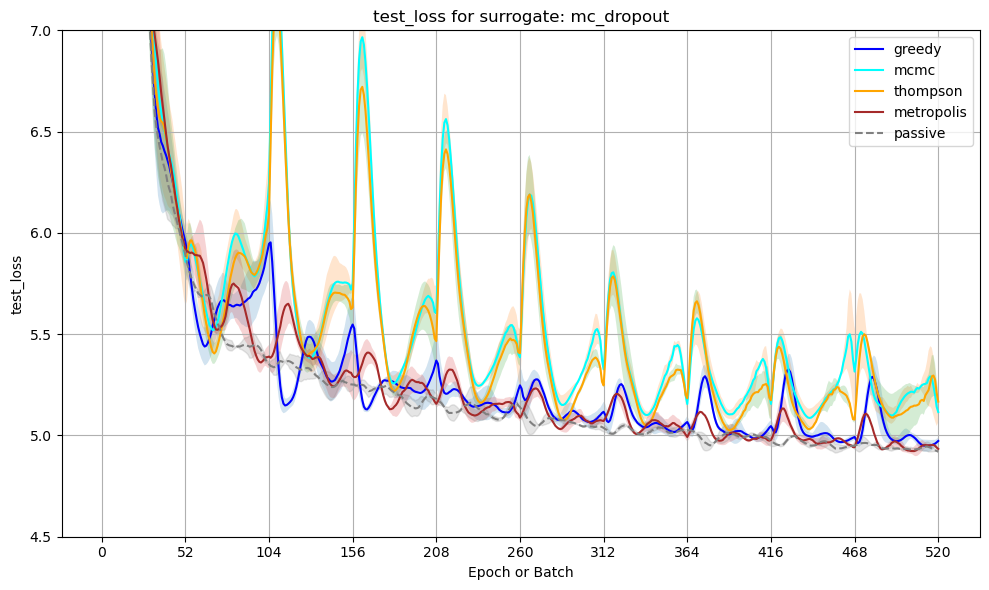

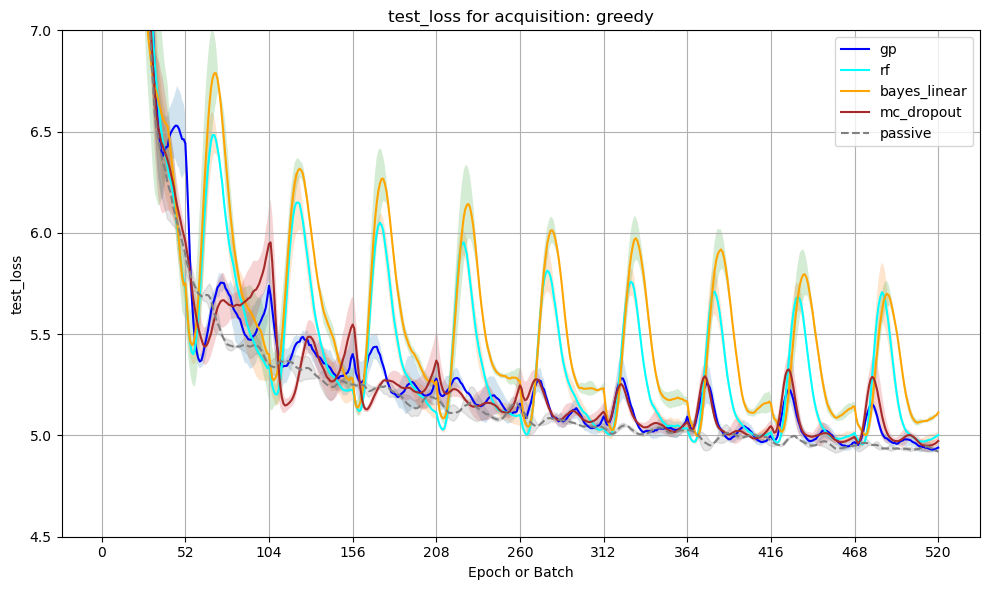

In [7]:
# 'gp', 'rf', 'bayes_linear', 'mc_dropout'
# 'greedy', 'mcmc', 'thompson', 'metropolis'
window = 9
x_l = 52 * window
x_u = 52 * (window + 1) + 1

plot_metric_grouped_by_acquisition(
    metric_key="test_loss",
    surrogate="mc_dropout",
    all_mean_metrics=all_mean_metrics,
    all_std_metrics=all_std_metrics,
    #xlim=(x_l, x_u),
    ylim=(4.5, 7)
)

plot_metric_grouped_by_surrogate(
    metric_key="test_loss",
    acquisition="greedy",
    all_mean_metrics=all_mean_metrics,
    all_std_metrics=all_std_metrics,
    #xlim=(x_l, x_u),
    ylim=(4.5, 7)
)

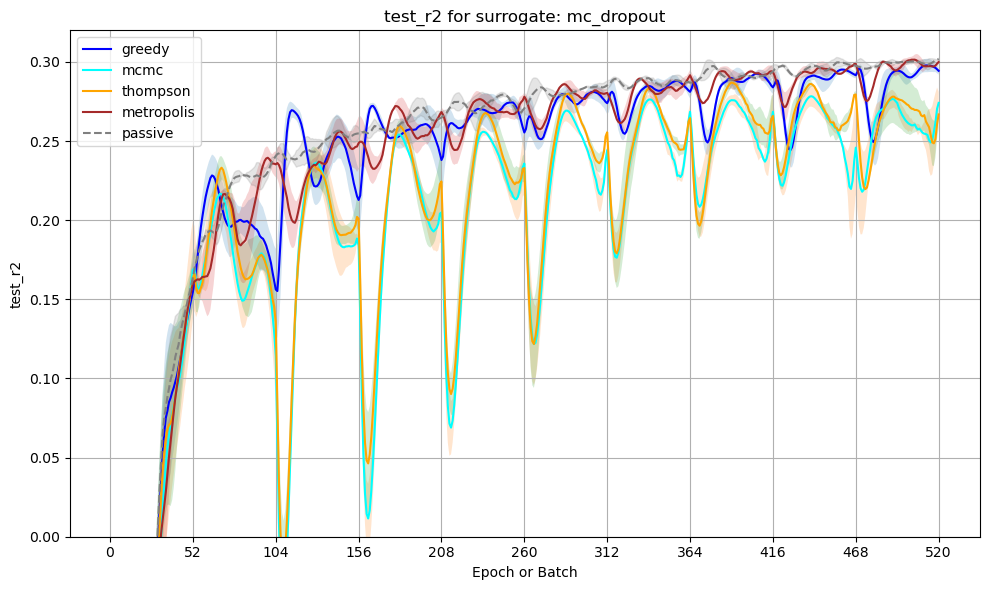

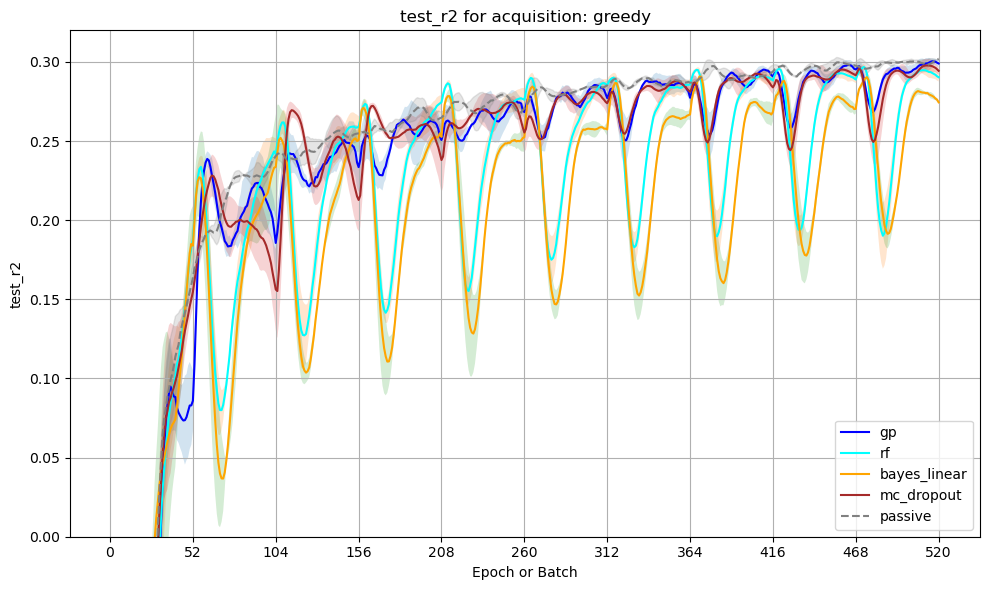

In [8]:
# 'gp', 'rf', 'bayes_linear', 'mc_dropout'
# 'greedy', 'mcmc', 'thompson', 'metropolis'
window = 9
x_l = 52 * window
x_u = 52 * (window + 1) + 1

plot_metric_grouped_by_acquisition(
    metric_key="test_r2",
    surrogate="mc_dropout",
    all_mean_metrics=all_mean_metrics,
    all_std_metrics=all_std_metrics,
    #xlim=(x_l, x_u),
    ylim=(0, .32)
)

plot_metric_grouped_by_surrogate(
    metric_key="test_r2",
    acquisition="greedy",
    all_mean_metrics=all_mean_metrics,
    all_std_metrics=all_std_metrics,
    #xlim=(x_l, x_u),
    ylim=(0, .32)
)